# data_utility.py
Implementation of dataset utility, including reading image, zooming, padding image
data augumentation
* 138 nii train image
* 46 nii test image

In [1]:
from data_utility import *
from data_utils import *
import elasticdeform
import imgaug.augmenters as iaa
import numpy as np

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from torchvision import transforms

test_dataset = pyramid_dataset(data_type = 'nii_train', 
                transform=transforms.Compose([
                random_affine(90, 15),
                random_filp(0.5)]))

test_dictionary = test_dataset[34]

* get_image(type, index, verbose)
    * pass

6
torch.Size([1, 256, 256, 256])


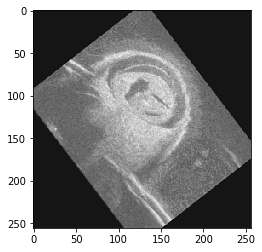

In [5]:
image = test_dictionary['image1_data']
#print(image.shape)
label = test_dictionary['image1_label']
bv_label = label[2, :, :, :]
print(len(test_dictionary))
print(image.shape)
show_image_slice(image)

113 108 134
117 105 136


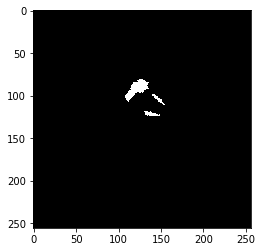

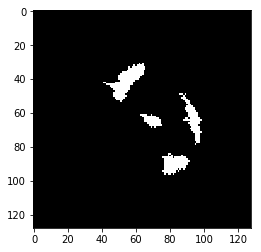

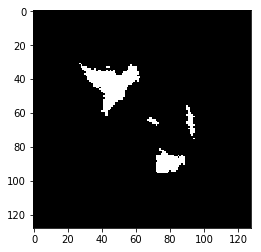

In [11]:
x1, y1, z1 = loadbvcenter(bv_label.view(1,256,256,256))
x2, y2, z2 = find_bv_centroid(bv_label.view(256,256,256))
print(x1, y1, z1)
print(x2, y2, z2)
show_image_slice(bv_label)
show_image_slice(bv_label[x1-64:x1+64, y1-64:y1+64, z1-64:z1+64])
show_image_slice(bv_label[x2-64:x2+64, y2-64:y2+64, z2-64:z2+64])

torch.Size([1, 256, 256, 256])
torch.Size([256, 256, 256])
121 121 102
118 121 104


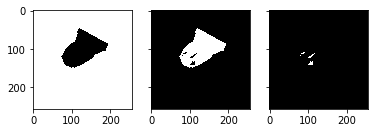

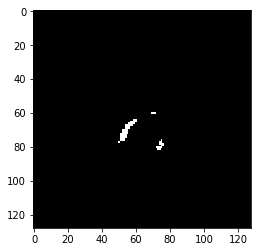

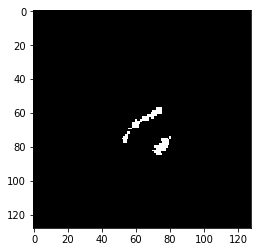

In [29]:
def loadbvcenter(img):
	'''
	get the bv center
	'''
	img = img.cpu().detach().numpy()
	bvmask = loadbvmask(img)
    
	x = int(np.mean(bvmask[0:2]))
	y = int(np.mean(bvmask[2:4]))
	z = int(np.mean(bvmask[4:6]))

	return x, y, z

def loadbvmask(img):
	'''
	Truely stupid and brutal force way to Find mask of BV
	'''
	img = (img > 0.66).astype(np.float32)
	# BVmask.shape = 1, X, Y, Z

	_, X, Y, Z = img.shape
	x1, y1, z1 = 0, 0, 0
	x2, y2, z2 = X-1, Y-1, Z-1

	while x1 < X:
		if (np.sum(img[:,x1,:,:]) > 0): # ~take a slice and check!
			break
		else:
			x1 += 1

	while y1 < Y:
		if (np.sum(img[:,:,y1,:]) > 0):
			break
		else:
			y1 += 1

	while z1 < Z:
		if (np.sum(img[:,:,:,z1]) > 0):
			break
		else:
			z1 += 1

	while x2 > 0:
		if (np.sum(img[:,x2,:,:]) > 0): 
			break
		else:
			x2 -= 1

	while y2 > 0:
		if (np.sum(img[:,:,y2,:]) > 0): 
			break
		else:
			y2 -= 1

	while z2 > 0:
		if (np.sum(img[:,:,:,z2]) > 0): 
			break
		else:
			z2 -= 1

	return np.array([x1, x2, y1, y2, z1, z2])

bv_label = label[2, :, :, :]

print(image.shape)
print(bv_label.shape)
a,b,c = loadbvcenter(bv_label.unsqueeze(0))
print(a,b,c)
x, y, z = find_bv_centroid(bv_label)
print(x,y,z)
show_image_slice(label)
show_image_slice(bv_label[x-64:x+64, y-64:y+64, z-64:z+64])
show_image_slice(bv_label[a-64:a+64, b-64:b+64, c-64:c+64])

tensor([135.2602, 112.6721, 151.3475])
tensor(135.2602)
tensor(112.6721)
tensor(151.3475)


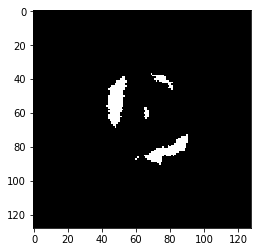

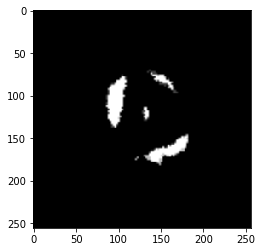

In [9]:
# BV
bv_label = label[2, :, :, :]
centroid = find_bv_centroid(bv_label)
print(centroid)
x = centroid[0]
y = centroid[1]
z = centroid[2]
print(x)
print(y)
print(z)

bbox = get_bounding_box_bv_label(bv_label, centroid)
show_image_slice(bbox)
up_bbox = F.interpolate(bbox.unsqueeze(0).unsqueeze(0), scale_factor=2, mode='trilinear', align_corners=True)
show_image_slice(up_bbox)

testing image 0


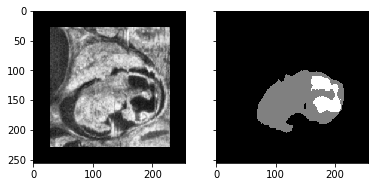

testing image 1


KeyboardInterrupt: 

In [3]:
record = np.zeros([138, 1, 256, 256, 256], dtype=np.float32)
for i in np.arange(138):
    print('testing image {}'.format(i))
    record[i] = get_image('nii_train', i, verbose=True)[0]

In [ ]:
print('mean of image is {}, std is {}'.format(np.mean(record), np.std(record)))

In [ ]:
for i in np.arange(46):
    print('testing image {}'.format(i))
    get_image('nii_test', i, verbose=True)

* affine_function(image, xr, yr, zr, xm, ym, zm)
    * can cause the image decay in memory, need to solve if load image to memory
* generate_pyramid(image)
    * pass
* filp_function(image, x, y, z)
    * can cause the image decay in memory, need to solve if load image to memory

In [ ]:
test_image = get_image('nii_train', 31, verbose=True)
print(test_image.shape)
show_image_slice(test_image)

In [ ]:
import ipyvolume as ipv
ipv.quickvolshow(test_image, level=[0,1], opacity=0.06, level_width=0.1, data_min=0, data_max=1)

In [ ]:
seq = iaa.Sequential([
    iaa.ElasticTransformation(alpha=256*2, sigma=256*0.08)
])
aug = seq.augment_images(test_image)
show_image_slice(aug)

In [ ]:
test_image_trans = affine_function(test_image, 30,30,30,0,0,0)
show_image_slice(test_image_trans)

In [ ]:
test_image_trans = filp_function(test_image, False, True, False)
show_image_slice(test_image_trans)

In [ ]:
#test_image_trans = elastic_transform(test_image, test_image.shape[1] * 2, test_image.shape[1] * 0.08)
test_image_trans = elasticdeform.deform_random_grid(test_image, sigma=0.25, points=3)
show_image_slice(test_image_trans)

In [ ]:
image1, image2, image4 = generate_pyramid(test_image)
show_image_slice(image1)
show_image_slice(image2)
show_image_slice(image4)

* pyramid_dataset(data_type, transform)
    * pass
* random_affine(fluR, fluM)
    * pass
* random_filp(p)
    * pass

In [26]:
test = torch.FloatTensor([[1, 0, 0], [0, 1, 0], [1, 0, 0]])
test_numpy = test.cpu().detach().numpy()
test = torch.from_numpy((test_numpy == test_numpy.max(axis=1)[:, None]).astype(float))
print(test)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]], dtype=torch.float64)


In [4]:
import ipyvolume as ipv
img_numpy = image.cpu().detach().numpy()
ipv.quickvolshow(img_numpy[0,:, :, :], level=[0,1], opacity=0.06, level_width=0.1, data_min=0, data_max=1)

/home/whd226/anaconda3/lib/python3.7/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


Volume(data=array([[[-0.70427036, -0.70427036, -0.70427036, ..., -0.70427036,
         -0.70427036, -0.7042703…

In [ ]:
x = img_numpy[0, 0, : ,:]
y = img_numpy[0, 1, :, :]
z = img_numpy[0, 2, :, :]
x, y = np.meshgrid(x,y)
ipv.figure()
#m = ipv.plot_mesh(x, y, z, wireframe=False)
m = ipv.plot_surface(x,y,z)
#ipv.squarelim()
ipv.show()

In [ ]:
%matplotlib notebook
from mpl_toolkits import mplot3d
import torch

def flatten(x):
    return x.view(-1)

img = image.squeeze(0)
print(img.shape)
#img = flatten(img)
#print(img.shape)
#img = img.cpu().detach().numpy()
x = flatten(img[0]).cpu().detach().numpy()
y = flatten(img[1]).cpu().detach().numpy()
z = flatten(img[2]).cpu().detach().numpy()
#print(z.shape)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z, 'gray')

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Download data set from plotly repo
img = image.squeeze(0)
print(img.shape)
#img = flatten(img)
#print(img.shape)
#img = img.cpu().detach().numpy()
x = flatten(img[0]).cpu().detach().numpy()
y = flatten(img[1]).cpu().detach().numpy()
z = flatten(img[2]).cpu().detach().numpy()

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers')])
fig.show()

In [ ]:
def show_image_slices(image):
    if torch.is_tensor(image):
        image = image.cpu().detach().numpy()
    
    image = np.squeeze(image)
    #print(np.transpose(image).shape)
    #print(image.shape)
    fig = plt.figure()
    if (len(image.shape)) == 3:
        x,y,z = image.shape
        a = 1
        for i in range(110, 170, 60 // 20):
            #print(i)
            fig.add_subplot(4, 6, a)
            plt.imshow(image[i], cmap='gray')
            a += 1
    if len(image.shape) == 4:
        channel,x,y,z = image.shape
        fig = plt.figure()
        
        for c in np.arange(channel):
            a = 1
            for i in range(120, 170, 50 // 10):
                fig.add_subplot(3, 4, a)
                plt.imshow(image[c][i],  cmap='gray')
                a += 1
    plt.show()
    pass
show_image_slices(image)
show_image_slices(label)

In [ ]:
show_image_slices(label)

In [ ]:
a = np.transpose(np.squeeze(image.cpu().detach().numpy()))
x = a[0]
y = a[1]
z = a[2]
print
fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50)])
fig.show()

In [ ]:
image = test_dictionary['image1_data']
print(image.shape)
#multi_slice_viewer(image)

In [ ]:
show_image_slice(test_dictionary['image1_data'])
show_image_slice(test_dictionary['image1_label'])

show_image_slice(test_dictionary['image2_data'])
show_image_slice(test_dictionary['image2_label'])

show_image_slice(test_dictionary['image4_data'])
show_image_slice(test_dictionary['image4_label'])

In [ ]:
get_image('nii_test', 33, verbose=True)

In [ ]:
show_image_slices(test_dictionary['image1_label'])